In [2]:
import jax.numpy as jnp
from jax import grad
import matplotlib.pyplot as plt
import numpy as np
from jax.scipy.optimize import minimize
from scipy.linalg import eigh
from functools import partial

## Mean-field of spin chain on semi-metal

## Using gradient descent 
- grad function from Jax

Jk_value, optimized_chi_ij, optimized_b_i= 0.5 -0.7026675939559937 1.5355306459241547e-05
Jk_value, optimized_chi_ij, optimized_b_i= 1 -0.7026675939559937 5.614932874209444e-08
Jk_value, optimized_chi_ij, optimized_b_i= 2 -0.7026674747467041 0.0006066414061933756
Jk_value, optimized_chi_ij, optimized_b_i= 2.5 -0.6476660370826721 0.41727983951568604
Jk_value, optimized_chi_ij, optimized_b_i= 3 -0.5354482531547546 0.6891239285469055


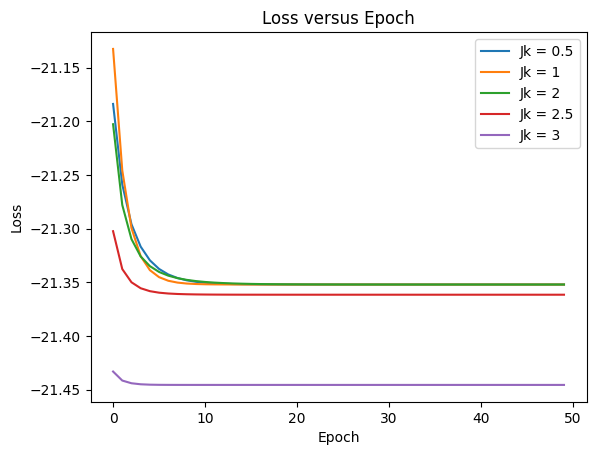

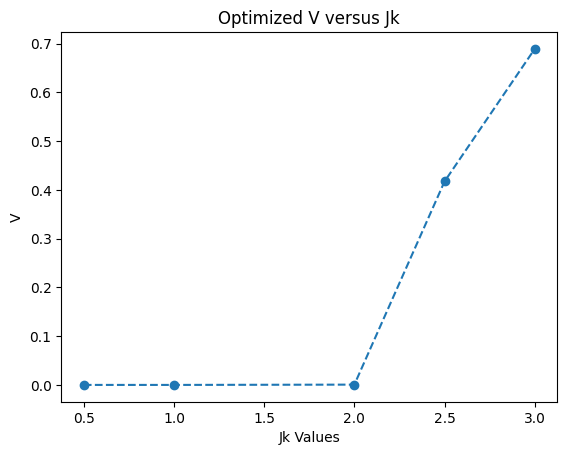

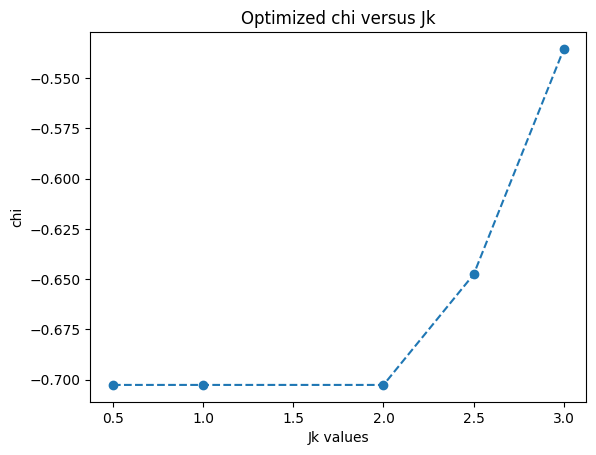

In [3]:
# Define your functions
def create_Hmat_1don2d(t_ij, chi_ij, b_i, mu_f, mu_c, Jh, Jk, rows, columns):
    Lx, Ly = rows + 1, columns + 1
    H_1don2d = jnp.zeros((Lx, Ly))
    eigenvalues_list = []

    for k in range(Lx):
        for i in range(rows + 1):
            for j in range(columns + 1):
                sign = 1 if i % 2 == 0 else -1 # for semimetal
               # sign = 1 if i % 2 == 0 else 1 # for metal
                diag_2d = -2 * t_ij * jnp.cos(2 * jnp.pi * k / Lx)
                diag_1d = Jh * -1. * chi_ij * jnp.cos(2 * jnp.pi * k / Lx)

                # Hopping along x-axis and chemical potential term
                if i < rows and j < columns and i == j:
                    H_1don2d = H_1don2d.at[i, j].set(diag_2d * sign + mu_c)
                elif i == rows and j == columns and i == j:
                    H_1don2d = H_1don2d.at[i, j].set(diag_1d + mu_f)
                
                elif i == 0 and j == Ly - 2:   # Boundary conditions
                    H_1don2d = H_1don2d.at[i, j].set(-t_ij)
                elif j == 0 and i == Lx - 2:   # Boundary conditions
                    H_1don2d = H_1don2d.at[i, j].set(-t_ij)
                # Hopping term in y direction
                elif i < rows and j < columns and abs(i - j) == 1:
                    H_1don2d = H_1don2d.at[i, j].set(-t_ij)
                            
                # Hybridisation term
                elif i == 0 and j == Ly - 1:   # Boundary conditions
                    H_1don2d = H_1don2d.at[i, j].set(-Jk * b_i / 2)
                elif j == 0 and i == Lx - 1:   # Boundary conditions
                    H_1don2d = H_1don2d.at[i, j].set(-Jk * b_i / 2)

        # Compute eigenvalues for each k
        eigenvalues, _ = jnp.linalg.eigh(H_1don2d)
        eigenvalues_list.append(eigenvalues)
    
    # Return eigenvalues matrix and H_1don2d
    return jnp.array(eigenvalues_list), H_1don2d

def e0val(Jk, Jh, b_i, chi_ij):
    e0 = (Jk * b_i**2 / 2.0) + (Jh * chi_ij**2 / 2.0)
    return e0

def compute_ground_state_energy(rows, e0, eigenvalues_list):
    # Compute the ground state energy
    e_ground = e0 + 2 * (jnp.sum(jnp.sum(jnp.minimum(eigenvalues_list, 0)))) / float(rows)
    return e_ground

def objective_function(params, Jk, rows, columns):
    chi_ij, b_i = params
    eigenvalues_list, _ = create_Hmat_1don2d(t_ij, chi_ij, b_i, mu_f, mu_c, Jh, Jk, rows, columns)
    e0 = e0val(Jk, Jh, b_i, chi_ij)
    return compute_ground_state_energy(rows, e0, eigenvalues_list)


if __name__ == "__main__":
    itr = 50
    Jh = 1
    t_ij = 1.0
    delta_ij = 0.0
    mu_f = 0.0
    mu_c = 0.0
    rows = 10
    columns = 10
    Jk_values = [0.5, 1, 2, 2.5, 3]
    eigenvalues_list = jnp.zeros((rows, columns))  # Placeholder for eigenvalues list
    optimized_b_values = []
    optimized_chi_values = []
    initial_params = jnp.array([-0.4, 0.8])

    for Jk_value in Jk_values:
        # Compute gradients of the objective function
        objective_grad = grad(objective_function)

        # Gradient Descent
        learning_rate = 0.5
        params = initial_params
        losses = []  # To store losses at each epoch
        for epoch in range(itr):  # Run for a fixed number of epochs
            loss = objective_function(params, Jk_value, rows, columns)
            losses.append(loss)
            grad_params = objective_grad(params, Jk_value, rows, columns)
            params = params - learning_rate * grad_params

        optimized_chi_ij, optimized_b_i = params
        optimized_chi_values.append(optimized_chi_ij)
        optimized_b_values.append(optimized_b_i)
        print(f'Jk_value, optimized_chi_ij, optimized_b_i= {Jk_value} {optimized_chi_ij} {optimized_b_i}')

        # Plot loss versus epoch
        plt.plot(range(itr), losses, label=f'Jk = {Jk_value}')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss versus Epoch')
    plt.legend()
    plt.show()

    # Plot optimized V versus Jk
    plt.plot(Jk_values, optimized_b_values, marker='o', linestyle='--')
    plt.xlabel('Jk Values')
    plt.ylabel('V')
    plt.title('Optimized V versus Jk')
    plt.show()

    # Plot optimized chi versus Jk
    plt.plot(Jk_values, optimized_chi_values, marker='o', linestyle='--')
    plt.xlabel('Jk values')
    plt.ylabel('chi')
    plt.title('Optimized chi versus Jk')
    plt.show()

## Using minimze functions from Jax

Jk_value, optimized_chi_ij, optimized_b_i= 3 -0.5354465246200562 0.6891273856163025
Jk_value, optimized_chi_ij, optimized_b_i= 2.5 -0.6476736068725586 0.41729477047920227
Jk_value, optimized_chi_ij, optimized_b_i= 2 -0.7026702165603638 1.3893935829401016e-05
Jk_value, optimized_chi_ij, optimized_b_i= 1.5 -0.7026702165603638 1.3893935829401016e-05
Jk_value, optimized_chi_ij, optimized_b_i= 1 -0.7026702165603638 1.3893935829401016e-05
Jk_value, optimized_chi_ij, optimized_b_i= 0.5 -0.7026702165603638 1.3893935829401016e-05


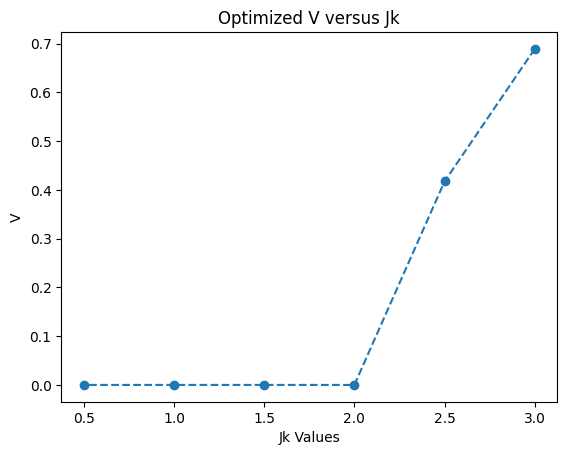

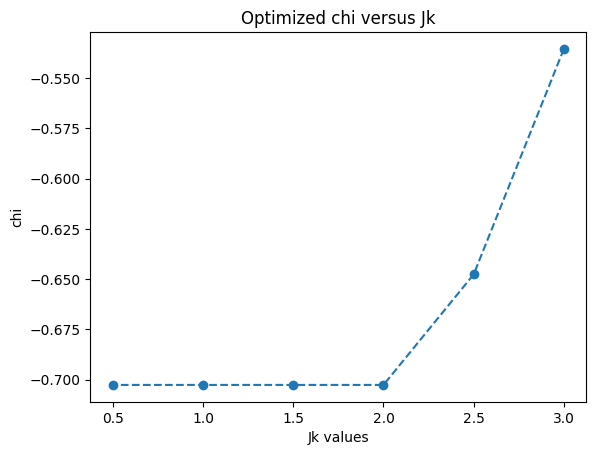

In [4]:
def create_Hmat_1don2d(t_ij, chi_ij, b_i, mu_f, mu_c, Jh, Jk, rows, columns):
    Lx, Ly = rows + 1, columns + 1
    H_1don2d = jnp.zeros((Lx, Ly))
    eigenvalues_list = []

    for k in range(Lx):
        for i in range(rows + 1):
            for j in range(columns + 1):
                sign = 1 if i % 2 == 0 else -1 
                diag_2d = -2 * t_ij * jnp.cos(2 * jnp.pi * k / Lx)
                diag_1d = Jh * -1. * chi_ij * jnp.cos(2 * jnp.pi * k / Lx)

                # Hopping along x-axis and chemical potential term
                if i < rows and j < columns and i == j:
                    H_1don2d = H_1don2d.at[i, j].set(diag_2d * sign + mu_c)
                elif i == rows and j == columns and i == j:
                    H_1don2d = H_1don2d.at[i, j].set(diag_1d + mu_f)
                
                elif i == 0 and j == Ly - 2:   # Boundary conditions
                    H_1don2d = H_1don2d.at[i, j].set(-t_ij)
                elif j == 0 and i == Lx - 2:   # Boundary conditions
                    H_1don2d = H_1don2d.at[i, j].set(-t_ij)
                # Hopping term in y direction
                elif i < rows and j < columns and abs(i - j) == 1:
                    H_1don2d = H_1don2d.at[i, j].set(-t_ij)
                            
                # Hybridisation term
                elif i == 0 and j == Ly - 1:   # Boundary conditions
                    H_1don2d = H_1don2d.at[i, j].set(-Jk * b_i / 2)
                elif j == 0 and i == Lx - 1:   # Boundary conditions
                    H_1don2d = H_1don2d.at[i, j].set(-Jk * b_i / 2)

        # Compute eigenvalues for each k
        eigenvalues, _ = jnp.linalg.eigh(H_1don2d)
        eigenvalues_list.append(eigenvalues)
    
    # Return eigenvalues matrix and H_1don2d
    return jnp.array(eigenvalues_list), H_1don2d

def e0val(Jk, Jh, b_i, chi_ij):
    e0 = (Jk * b_i**2 / 2.0) + (Jh * chi_ij**2 / 2.0)
    return e0

def compute_ground_state_energy(rows, e0, eigenvalues_list):
    # Compute the ground state energy
    e_ground = e0 + 2 * (jnp.sum(jnp.sum(jnp.minimum(eigenvalues_list, 0)))) / float(rows)
    return e_ground

def objective_function_jax(params, Jk, rows, eigenvalues_list):
    chi_ij, b_i = params
    eigenvalues_list, _ = create_Hmat_1don2d(t_ij, chi_ij, b_i, mu_f, mu_c, Jh, Jk, rows, columns)
    e0 = e0val(Jk, Jh, b_i, chi_ij)
    return compute_ground_state_energy(rows, e0, eigenvalues_list)

def objective_function_wrapper(params, Jk, rows, eigenvalues_list):
    params = jnp.array(params)
    return objective_function_jax(params, Jk, rows, eigenvalues_list)

def optimize_for_Jk(Jk_value, initial_params, rows, columns):
    Jk = Jk_value
    # Assuming `t_ij`, `mu_f`, `mu_c`, `Jh` are defined globally or passed as arguments
    result = minimize(partial(objective_function_wrapper, Jk=Jk, rows=rows, eigenvalues_list=None), 
                      x0=initial_params, method='BFGS')
    optimized_chi_ij, optimized_b_i = result.x
    initial_params = result.x
    print(f'Jk_value, optimized_chi_ij, optimized_b_i= {Jk_value} {optimized_chi_ij} {optimized_b_i}')
    return optimized_chi_ij, optimized_b_i, initial_params

if __name__ == "__main__":
    Jh = 1
    t_ij = 1.0
    delta_ij = 0.0
    mu_f = 0.0
    mu_c = 0.0
    rows = 10
    columns = 10
    Jk_values = [3, 2.5,  2, 1.5,  1, 0.5]
    # Assuming `Jh`, `t_ij`, `mu_f`, `mu_c`, `rows`, `columns`, and `Jk_values` are defined globally or passed as arguments
    # Initialize eigenvalues_list with a placeholder value
    eigenvalues_list = jnp.zeros((rows, columns)) 
    optimized_b_values = []
    optimized_chi_values = []
    initial_params = jnp.array([0.4, 8])

    for Jk_value in Jk_values:
        optimized_chi_ij, optimized_b_i, initial_params = optimize_for_Jk(Jk_value, initial_params.copy(), rows, columns)
        optimized_chi_values.append(optimized_chi_ij)
        optimized_b_values.append(optimized_b_i)
    #Plot optimized V versus Jk
    plt.plot(Jk_values, optimized_b_values, marker='o', linestyle = '--')
    plt.xlabel('Jk Values')
    plt.ylabel('V')
    plt.title('Optimized V versus Jk')
    plt.show()
    plt.plot(Jk_values, optimized_chi_values, marker='o', linestyle = '--')
    plt.xlabel('Jk values')
    plt.ylabel('chi')
    plt.title('Optimized chi versus Jk')
